## Import Packages


In [149]:
# This cell will throw an error the first time. Run it once more to fix it.
import numpy as np
import os
import pandas as pd
import random
import math

os.environ["KERAS_BACKEND"] = "tensorflow"
from sklearn.model_selection import train_test_split

!pip install -q tensorflow
!pip install -q tensorflow-model-optimization
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

import gzip
import tempfile
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import balanced_accuracy_score
from IPython.display import Image, display
import matplotlib.cm as cm
import tempfile

## Mount Drive & Load Data

In [150]:
#mount drive
from google.colab import drive

drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/CS528_Final_Project/data/track_2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/CS528_Final_Project/data/track_2


In [151]:
# Load datasets

# Original Dataset
train_imgs = np.load('train_dataset_initial_cleaned.npz')['X_data']
train_labels = np.load('train_dataset_initial_cleaned.npz')['Y_data']

val_imgs = np.load('val_dataset_initial_cleaned.npz')['X_data']
val_labels = np.load('val_dataset_initial_cleaned.npz')['Y_data']

test_imgs = np.load('test_dataset_initial.npz')['X_data']
test_labels = np.load('test_dataset_initial.npz')['Y_data']

# Another training dataset collected at a separate time
train_imgs2 = np.load('train_rc_dataset2.npz')['X_data']
train_labels2 = np.load('train_rc_dataset2.npz')['Y_data']

val_imgs2 = np.load('val_rc_dataset2.npz')['X_data']
val_labels2 = np.load('val_rc_dataset2.npz')['Y_data']

test_imgs2 = np.load('test_rc_dataset2.npz')['X_data']
test_labels2 = np.load('test_rc_dataset2.npz')['Y_data']

# DAgger Data
N_DAGGER_ITERS = 1
dagger_imgs = []
dagger_labels = []

for i in range(1, N_DAGGER_ITERS + 1):
  dagger_imgs.append(np.load('train_dagger2_iter_' + str(i) + '.npz')['X_data'])
  dagger_labels.append(np.load('train_dagger2_iter_' + str(i) + '.npz')['Y_data'])


## Dataset Info

In [152]:
# Shape
print("Original Train images shape:", train_imgs.shape)
print("Original Train Labels shape:", train_labels.shape)
print()
print("Original Val images shape:", val_imgs.shape)
print("Original Val labels shape:", val_labels.shape)
print()
print("Original Test images shape:", test_imgs.shape)
print("Original Test labels shape:", test_labels.shape)
print()
print("Second Train images shape:", train_imgs2.shape)
print("Second Train labels shape:", train_labels2.shape)
print()
print("Second Val images shape:", val_imgs2.shape)
print("Second Val labels shape:", val_labels2.shape)
print()
print("Second Test images shape:", test_imgs2.shape)
print("Second Test labels shape:", test_labels2.shape)
print()
print("Newest Dagger Shape: ", dagger_imgs[-1].shape)

Original Train images shape: (57545, 60, 80, 3)
Original Train Labels shape: (57545, 22)

Original Val images shape: (14028, 60, 80, 3)
Original Val labels shape: (14028, 22)

Original Test images shape: (13646, 60, 80, 3)
Original Test labels shape: (13646, 22)

Second Train images shape: (15842, 60, 80, 3)
Second Train labels shape: (15842, 22)

Second Val images shape: (1928, 60, 80, 3)
Second Val labels shape: (1928, 22)

Second Test images shape: (1822, 60, 80, 3)
Second Test labels shape: (1822, 22)

Newest Dagger Shape:  (5002, 60, 80, 3)


## Combine Original Data with New Data and DAgger Data

In [153]:
def take_n_percent(X, y, n):
    n = int(len(X) * n)
    idx = np.random.choice(len(X), size=n, replace=False)
    return X[idx], y[idx]

# Undersample original training dataset
train_imgs_20, train_labels_20 = take_n_percent(train_imgs, train_labels, 0.5)
val_imgs_20, val_labels_20   = take_n_percent(val_imgs, val_labels,  0.5)
test_imgs_20, test_labels_20 = take_n_percent(test_imgs, test_labels, 0.5)

# Concatenate both training datasets
X_train = np.concatenate([train_imgs_20, train_imgs2], axis=0)
y_train = np.concatenate([train_labels_20, train_labels2], axis=0)

X_val = np.concatenate([val_imgs_20, val_imgs2], axis=0)
y_val = np.concatenate([val_labels_20, val_labels2], axis=0)

X_test = np.concatenate([test_imgs_20, test_imgs2], axis=0)
y_test = np.concatenate([test_labels_20, test_labels2], axis=0)

# Shuffle Everything Up
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

train_imgs, train_labels = shuffle(X_train, y_train)
val_imgs, val_labels    = shuffle(X_val, y_val)
test_imgs, test_labels   = shuffle(X_test, y_test)

In [154]:
# Add DAgger Data to Training

all_dagger = np.concatenate(dagger_imgs, axis=0)
all_dagger_labels = np.concatenate(dagger_labels, axis=0)

train_imgs = np.concatenate([train_imgs, all_dagger], axis=0)
train_labels = np.concatenate([train_labels, all_dagger_labels], axis=0)

# Shuffle
perm = np.random.permutation(len(train_imgs))
train_imgs = train_imgs[perm]
train_labels = train_labels[perm]

print("Total: ", train_imgs.shape)

Total:  (49616, 60, 80, 3)


## Data Augmentation

Horizontal Flip of Images (Also flips steering label).

In [155]:
FLIP_AUGMENTATION = False

if FLIP_AUGMENTATION:
  steering_col = train_labels[:, -1]
  indices = np.where((steering_col == -1) | (steering_col == 1))[0]

  train_imgs_steering_only = train_imgs[indices].copy()
  train_labels_steering_only = train_labels[indices].copy()

  train_imgs_flipped = tf.image.flip_left_right(train_imgs_steering_only)

  # Flip steering values
  train_labels_steering_only[:, -1] = train_labels_steering_only[:, -1] * -1

  # Append to flipped data to original data
  train_imgs = np.concatenate([train_imgs, train_imgs_flipped], axis=0)
  train_labels = np.concatenate([train_labels, train_labels_steering_only], axis=0)
else:
  print("Flip Augmentation is Turned Off")

Flip Augmentation is Turned Off


We found other augmentation techniques such as random brightness shifts to be effective.

In [156]:
# A selection of augmentation techniques (must be added to augment_image pipeline to take effect)
rotation = keras.layers.RandomRotation(0.01)
translation = keras.layers.RandomTranslation(0.05, 0.05)
zoom = keras.layers.RandomZoom(0.01)
brightness = keras.layers.RandomBrightness(0.0015)
noise = keras.layers.GaussianNoise(0.015)

def augment_image(img):
    img = brightness(img, training=True)
    return img

# Apply to dataset
augmented_train_imgs = augment_image(train_imgs)

### Vizualize Augmentation

Top row are original images. Bottom row is after augmentation



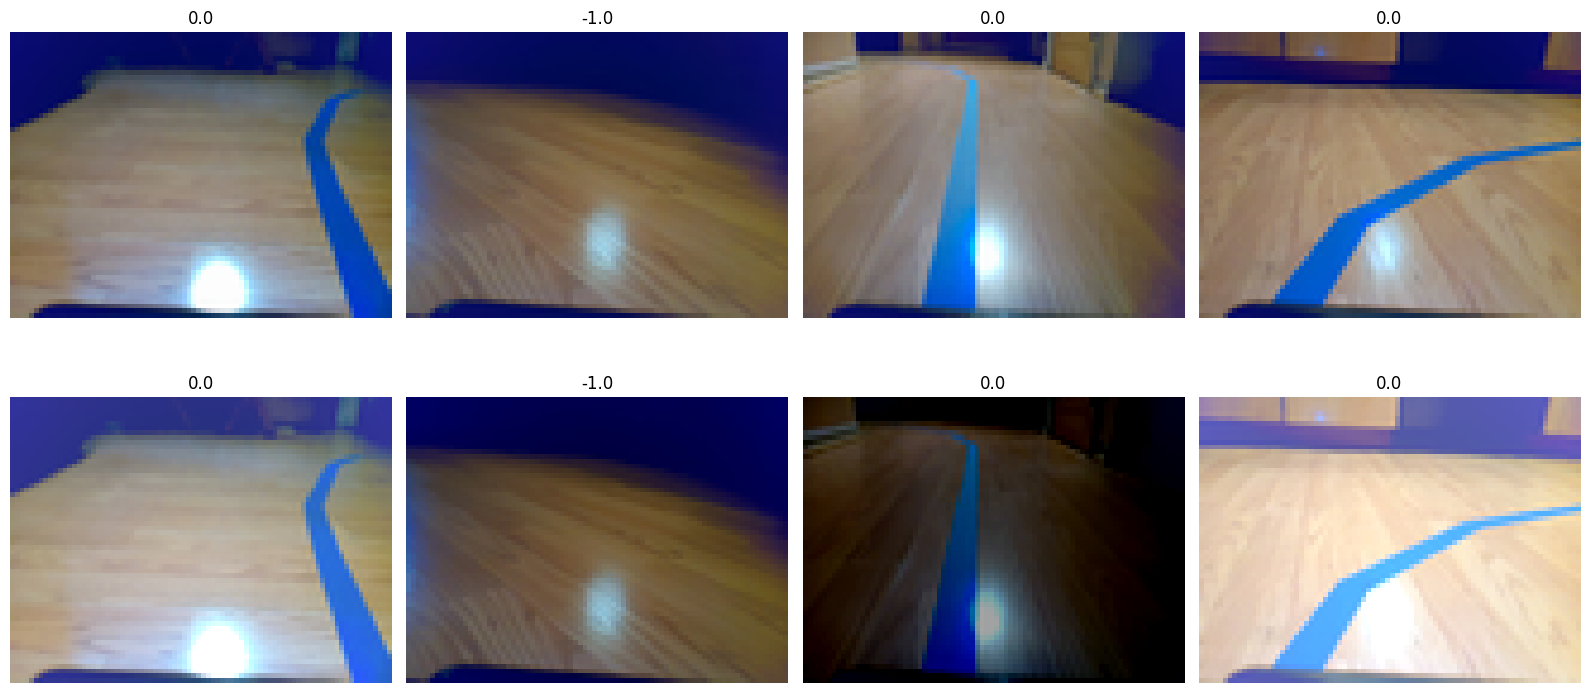

In [157]:
plt.figure(figsize=(16, 8))

indices = [random.randint(0, len(train_imgs) - 1) for _ in range(4)]

# Top row: original images
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(train_imgs[idx])
    plt.title(train_labels[idx][-1])
    plt.axis("off")

# Bottom row: augmented images (same indices)
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(augmented_train_imgs[idx])
    plt.title(train_labels[idx][-1])
    plt.axis("off")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of Steering Commands')

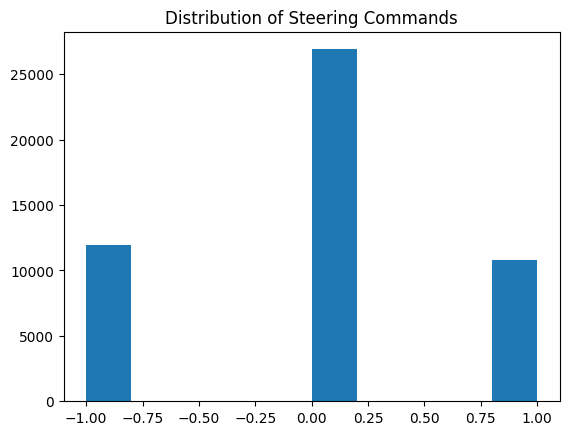

In [158]:
plt.hist(train_labels[:,-1])
plt.title("Distribution of Steering Commands")

## Preprocess Metadata

We experimented with including various metadata along with images in our model. This included past steering history, as well as information on the current throttle of the car. We found this metadata not to help, so we stopped using it in our models.


In [159]:
# First value is timestep, then the next 20 values are previous steering commands from the last 2 seconds (taken at 0.1s intervals)
# Following this is the index within the throttle pulse cycle it is. (Throttle is on for 15 then off for 45 iterations so idx captures where in the 60 iteration cycle it is)
# Finally is the expert steering command

train_metadata = train_labels[:,:-1]
val_metadata = val_labels[:,:-1]
test_metadata = test_labels[:,:-1]

# Change Steering angles from range [-1, 1] to [0,2]
Y_train = train_labels[:,-1] + 1
Y_val =  val_labels[:,-1] + 1
Y_test = test_labels[:,-1] + 1

# Do the same for the steering lookback
train_metadata[:,0: -1] +=1
test_metadata[:,0:-1] +=1
val_metadata[:,0:-1] +=1

# Normalize Throttle Pulse Index
train_metadata[:,-1] /= 59
test_metadata[:,-1] /= 59
val_metadata[:,-1] /= 59


# Only Use Throttle Period For Now
train_metadata = train_metadata[:,-1]
test_metadata = test_metadata[:,-1]
val_metadata = val_metadata[:,-1]

##CNN

In [160]:
# Converts image from RBG to YUV
def image_rgb_to_yuv(x):
  x = tf.image.rgb_to_yuv(x)
  return x

In [161]:
image_input = keras.Input(shape=(60, 80, 3))
# Crop the top 25 pixels
# x = keras.layers.Cropping2D(cropping=((25, 0), (0, 0)))(image_input)

# # Convert from RGB to YUV
# x = keras.layers.Lambda(image_rgb_to_yuv)(x)

x = keras.layers.Conv2D(24, 5, padding='same', use_bias=False)(image_input)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)


x = keras.layers.Conv2D(36, 5, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Conv2D(48, 3, strides=2, padding='same', use_bias=False)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

# Assign name to final conv layer to be used for GradCAM
x = keras.layers.Conv2D(48, 7, strides=7, padding='same', use_bias=False, name='final_conv')(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.35)(x)

x = keras.layers.Dense(64)(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.35)(x)

x = keras.layers.Dense(24, kernel_regularizer=regularizers.l2(1e-4))(x)
x = keras.layers.BatchNormalization(center=True, scale=False)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.2)(x)

output = keras.layers.Dense(3, activation='softmax')(x)


model = keras.Model(inputs=[image_input], outputs=output)

model.summary()


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 80, 24)        1800      
                                                                 
 batch_normalization_24 (Ba  (None, 60, 80, 24)        72        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 60, 80, 24)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 40, 36)        21600     
                                                                 
 batch_normalization_25 (Ba  (None, 30, 40, 36)        108       
 tchNormalization)                                        

In [162]:
# Class weights can be used to emphasize under-represented classes
class_weight = {
    0: 1.4,
    1: 1.0,
    2: 1.0
}

def lr_decay(epoch):
    return 0.04 * math.pow(0.93, epoch)

checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

lr_decay_callback = keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_weights_only=True,
    save_best_only=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=False
)

history = model.fit(
    [augmented_train_imgs],
    Y_train,
    epochs=30,
    batch_size=32,
    validation_data=([val_imgs], Y_val),
    class_weight=class_weight,
    callbacks=[lr_decay_callback, early_stop, model_checkpoint_callback]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.04.
Epoch 1/30
1551/1551 [==============================] - 16s 8ms/step - loss: 0.7833 - accuracy: 0.7109 - val_loss: 0.4314 - val_accuracy: 0.8276 - lr: 0.0400

Epoch 2: LearningRateScheduler setting learning rate to 0.037200000000000004.
Epoch 2/30
1551/1551 [==============================] - 11s 7ms/step - loss: 0.7011 - accuracy: 0.7553 - val_loss: 0.5090 - val_accuracy: 0.7919 - lr: 0.0372

Epoch 3: LearningRateScheduler setting learning rate to 0.03459600000000001.
Epoch 3/30
1551/1551 [==============================] - 11s 7ms/step - loss: 0.6720 - accuracy: 0.7608 - val_loss: 0.4013 - val_accuracy: 0.8380 - lr: 0.0346

Epoch 4: LearningRateScheduler setting learning rate to 0.032174280000000006.
Epoch 4/30
1551/1551 [==============================] - 11s 7ms/step - loss: 0.6511 - accuracy: 0.7689 - val_loss: 0.4169 - val_accuracy: 0.8465 - lr: 0.0322

Epoch 5: LearningRateScheduler setting learning rate to 0.0299220804

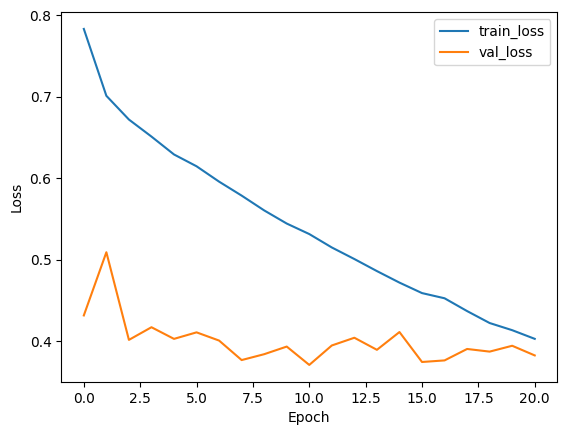

In [163]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [164]:
# # Load best weights based on val loss
# model.load_weights(checkpoint_filepath)
model.load_weights(checkpoint_filepath)

def get_zipped_model_size_and_accuracy(model):
  # Compile
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  # Record accuracy
  test_accuracy = model.evaluate([test_imgs],  Y_test)[1]


  # Save as h5
  _, temp_h5_path = tempfile.mkstemp('.h5')
  _, temp_zip_path = tempfile.mkstemp('.zip')
  model.save(temp_h5_path, include_optimizer=False)

  # Zip
  with zipfile.ZipFile(temp_zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
      f.write(temp_h5_path, arcname='model.h5')
  size_kb = os.path.getsize(temp_zip_path) / 1024.0

  # Print accuracy and size
  print("Test Accuracy: ", test_accuracy)
  print("Model Size: ", size_kb, "KB")


get_zipped_model_size_and_accuracy(model)

271/271 [==============================] - 1s 3ms/step - loss: 0.4774 - accuracy: 0.8045
Test Accuracy:  0.8045112490653992
Model Size:  665.7607421875 KB


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tf_keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'keras.src.regularizers.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


In [165]:
y_pred = np.argmax(model.predict([test_imgs]), axis=1)
balanced_accuracy_score(Y_test, y_pred)

271/271 [==============================] - 1s 2ms/step


np.float64(0.6772519434288542)

271/271 [==============================] - 1s 2ms/step


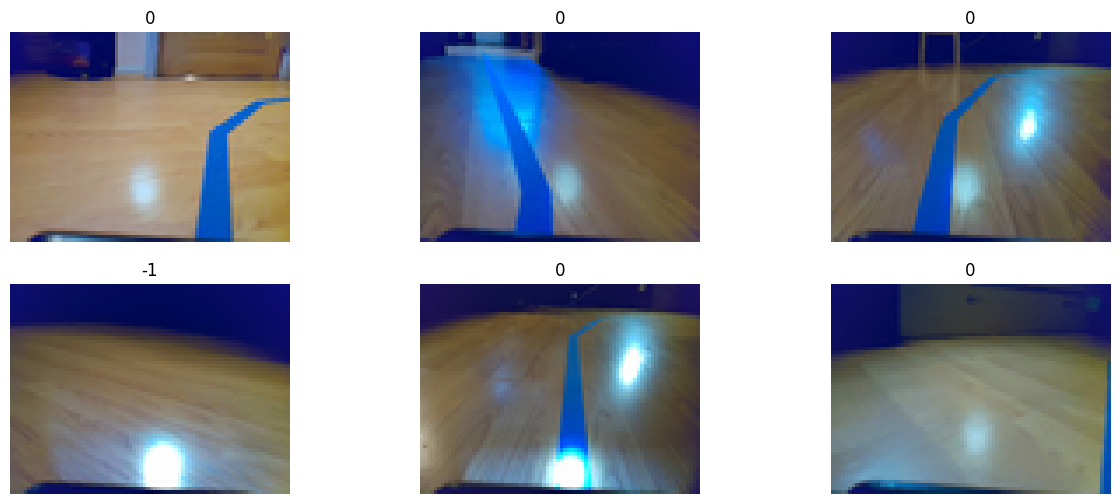

In [166]:
predictions = model.predict([test_imgs])
plt.figure(figsize=(15, 6))

for i in range(6):
  random_index = random.randint(0, len(test_imgs) - 1)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(test_imgs[random_index])

  # Throttle, steering direction
  plt.title(np.argmax(predictions[random_index])-1)
  plt.axis("off")

plt.show()

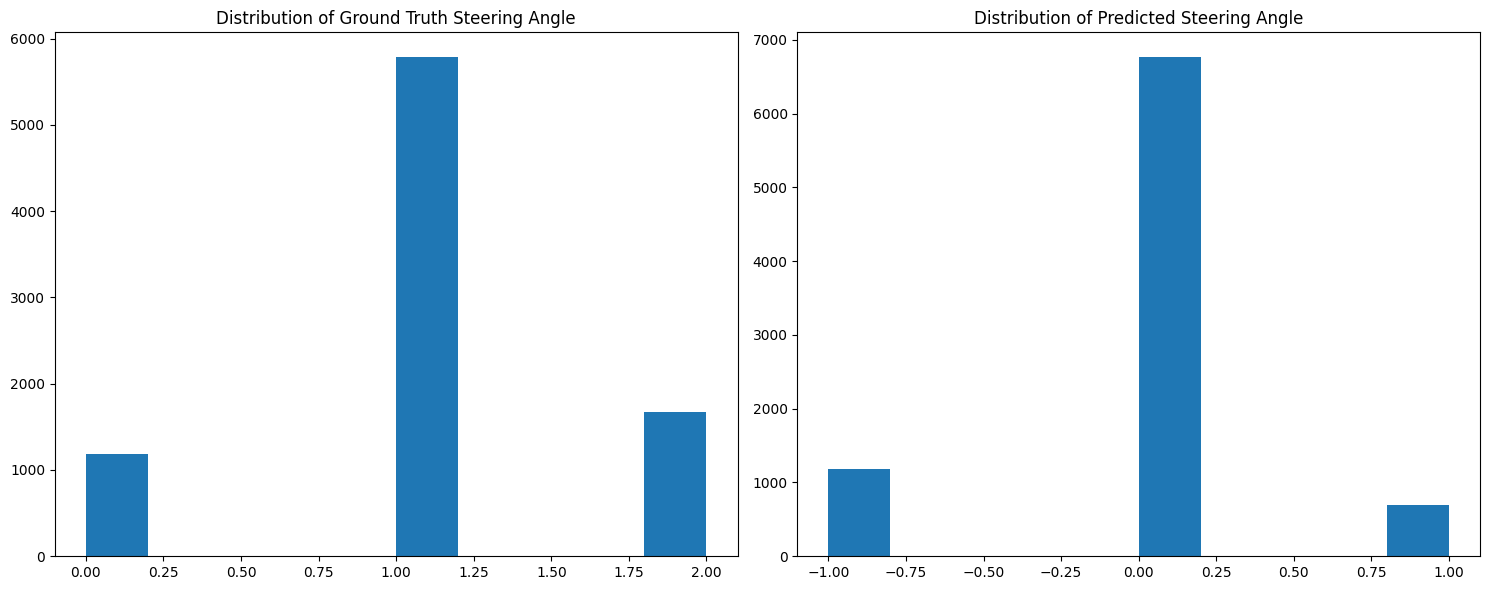

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax2.hist(np.argmax(predictions, axis=1)-1)
ax2.set_title("Distribution of Predicted Steering Angle")
ax1.hist(Y_test)
ax1.set_title("Distribution of Ground Truth Steering Angle")

plt.tight_layout()
plt.show()

# Grad-CAM

In [168]:
# All Grad-CAM code is from Module 11 Slides Part 2

import tf_keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf_keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # The gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="/tmp/cam.jpg", alpha=0.004):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use viridis colormap to colorize heatmap
    viridis = cm.get_cmap("viridis")

    # Use RGB values of the colormap
    viridis_colors = viridis(np.arange(256))[:, :3]
    viridis_heatmap = viridis_colors[heatmap]

    # Create an image with RGB colorized heatmap
    viridis_heatmap = keras.preprocessing.image.array_to_img(viridis_heatmap)
    viridis_heatmap = viridis_heatmap.resize((img.shape[1], img.shape[0]))
    viridis_heatmap = keras.preprocessing.image.img_to_array(viridis_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = viridis_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

/tmp/ipython-input-4173209217.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


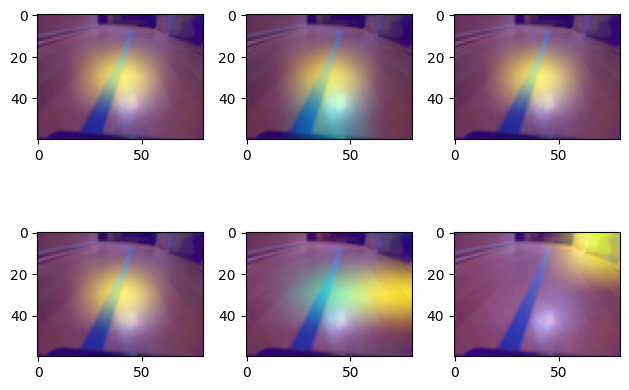

In [169]:
# Save original softmax
last_layer_softmax = model.layers[-1].activation

# Remove last layer's softmax
model.layers[-1].activation = None

last_conv_layer_name = 'final_conv'

# Plot 6 random GradCAM images
for i in range(6):
  random_index = random.randint(0, len(test_imgs) - 1)
  ax = plt.subplot(2, 3, i + 1)
  img_array = test_imgs[random_index]

  # Add a "batch" dimension to the image array
  img_array = np.expand_dims(img_array, axis=0)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  plt.imshow(save_and_display_gradcam(test_imgs[0], heatmap))

plt.tight_layout()
plt.show()

In [170]:
# Set back softmax
model.layers[-1].activation = last_layer_softmax

## Pruning, Clustering, and Quantization

### Pruning

In [171]:
# Navigate back to /content/drive/MyDrive/CS528_Final_Project
%cd ..

!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 128
epochs = 5
num_images = train_imgs.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model.fit([augmented_train_imgs], Y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=([val_imgs], Y_val),
                  callbacks=callbacks)


/content/drive/MyDrive/CS528_Final_Project/data
Epoch 1/5
388/388 [==============================] - 16s 20ms/step - loss: 0.5778 - accuracy: 0.7784 - val_loss: 0.3980 - val_accuracy: 0.8465
Epoch 2/5
388/388 [==============================] - 7s 18ms/step - loss: 0.5563 - accuracy: 0.7860 - val_loss: 0.3958 - val_accuracy: 0.8452
Epoch 3/5
388/388 [==============================] - 7s 17ms/step - loss: 0.5481 - accuracy: 0.7868 - val_loss: 0.3914 - val_accuracy: 0.8467
Epoch 4/5
388/388 [==============================] - 7s 17ms/step - loss: 0.5376 - accuracy: 0.7878 - val_loss: 0.3812 - val_accuracy: 0.8473
Epoch 5/5
388/388 [==============================] - 7s 17ms/step - loss: 0.5314 - accuracy: 0.7913 - val_loss: 0.3800 - val_accuracy: 0.8461


In [172]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

In [173]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

print_model_weights_sparsity(stripped_pruned_model)

stripped_pruned_model.summary()

get_zipped_model_size_and_accuracy(stripped_pruned_model)

conv2d_13/kernel:0: 50.00% sparsity  (900/1800)
conv2d_14/kernel:0: 50.00% sparsity  (10800/21600)
conv2d_15/kernel:0: 50.00% sparsity  (7776/15552)
final_conv/kernel:0: 50.00% sparsity  (56448/112896)
dense_12/kernel:0: 50.00% sparsity  (13824/27648)
dense_13/kernel:0: 50.00% sparsity  (768/1536)
dense_14/kernel:0: 50.00% sparsity  (36/72)
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 60, 80, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 80, 24)        1800      
                                                                 
 batch_normalization_24 (Ba  (None, 60, 80, 24)        72        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 60, 80, 2

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tf_keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'keras.src.regularizers.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


### Sparsity Preserving Weight Clustering

In [174]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

sparsity_clustered_model = cluster_weights(stripped_pruned_model, **clustering_params)

sparsity_clustered_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print('Train sparsity preserving clustering model:')
sparsity_clustered_model.fit([augmented_train_imgs],
                             Y_train,
                             epochs=5,
                             validation_data=([val_imgs], Y_val)),

Train sparsity preserving clustering model:
Epoch 1/5
1551/1551 [==============================] - 25s 12ms/step - loss: 0.4800 - accuracy: 0.8060 - val_loss: 0.3775 - val_accuracy: 0.8439
Epoch 2/5
1551/1551 [==============================] - 17s 11ms/step - loss: 0.4678 - accuracy: 0.8095 - val_loss: 0.3684 - val_accuracy: 0.8481
Epoch 3/5
1551/1551 [==============================] - 17s 11ms/step - loss: 0.4585 - accuracy: 0.8121 - val_loss: 0.3682 - val_accuracy: 0.8480
Epoch 4/5
1551/1551 [==============================] - 16s 11ms/step - loss: 0.4500 - accuracy: 0.8153 - val_loss: 0.3696 - val_accuracy: 0.8480
Epoch 5/5
1551/1551 [==============================] - 18s 12ms/step - loss: 0.4430 - accuracy: 0.8179 - val_loss: 0.3783 - val_accuracy: 0.8478


(<tf_keras.src.callbacks.History at 0x7c316c94c2c0>,)

In [175]:
stripped_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

print("Model sparsity:\n")
print_model_weights_sparsity(stripped_clustered_model)

print("\nModel clusters:\n")
print_model_weight_clusters(stripped_clustered_model)

get_zipped_model_size_and_accuracy(stripped_clustered_model)

Model sparsity:

kernel:0: 50.72% sparsity  (913/1800)
kernel:0: 58.13% sparsity  (12557/21600)
kernel:0: 52.57% sparsity  (8175/15552)
kernel:0: 61.72% sparsity  (69682/112896)
kernel:0: 51.75% sparsity  (14307/27648)
kernel:0: 75.59% sparsity  (1161/1536)
kernel:0: 54.17% sparsity  (39/72)

Model clusters:

conv2d_13/kernel:0: 8 clusters 
conv2d_14/kernel:0: 8 clusters 
conv2d_15/kernel:0: 8 clusters 
final_conv/kernel:0: 8 clusters 
dense_12/kernel:0: 8 clusters 
dense_13/kernel:0: 7 clusters 
dense_14/kernel:0: 8 clusters 
271/271 [==============================] - 1s 3ms/step - loss: 0.3850 - accuracy: 0.8511
Test Accuracy:  0.8511278033256531
Model Size:  83.3994140625 KB


## Pruned, Clustered, Quantization-Aware Trained (PCQAT) Model

In [176]:
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              stripped_clustered_model)
pcqat_model = tfmot.quantization.keras.quantize_apply(
              quant_aware_annotate_model,
              tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(preserve_sparsity=True))

pcqat_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
print('Train pcqat model:')
pcqat_model.fit([augmented_train_imgs],
                Y_train,
                batch_size=128, epochs=5,
                validation_data=([val_imgs], Y_val))

Train pcqat model:
Epoch 1/5


388/388 [==============================] - 23s 30ms/step - loss: 0.5374 - accuracy: 0.7856 - val_loss: 0.3711 - val_accuracy: 0.8504
Epoch 2/5
388/388 [==============================] - 11s 29ms/step - loss: 0.5311 - accuracy: 0.7856 - val_loss: 0.3727 - val_accuracy: 0.8507
Epoch 3/5
388/388 [==============================] - 11s 27ms/step - loss: 0.5200 - accuracy: 0.7908 - val_loss: 0.3703 - val_accuracy: 0.8494
Epoch 4/5
388/388 [==============================] - 11s 27ms/step - loss: 0.5201 - accuracy: 0.7913 - val_loss: 0.3662 - val_accuracy: 0.8517
Epoch 5/5
388/388 [==============================] - 11s 27ms/step - loss: 0.5157 - accuracy: 0.7939 - val_loss: 0.3644 - val_accuracy: 0.8494


In [177]:
print("\nPCQAT Model clusters:")
print_model_weight_clusters(pcqat_model)
print("\nPCQAT Model sparsity:")
print_model_weights_sparsity(pcqat_model)


PCQAT Model clusters:
quant_conv2d_13/conv2d_13/kernel:0: 8 clusters 
quant_conv2d_14/conv2d_14/kernel:0: 8 clusters 
quant_conv2d_15/conv2d_15/kernel:0: 8 clusters 
quant_final_conv/final_conv/kernel:0: 337 clusters 
quant_dense_12/dense_12/kernel:0: 8 clusters 
quant_dense_13/dense_13/kernel:0: 140 clusters 
quant_dense_14/dense_14/kernel:0: 8 clusters 

PCQAT Model sparsity:
conv2d_13/kernel:0: 50.78% sparsity  (914/1800)
conv2d_14/kernel:0: 58.47% sparsity  (12629/21600)
conv2d_15/kernel:0: 54.13% sparsity  (8418/15552)
final_conv/kernel:0: 61.74% sparsity  (69699/112896)
dense_12/kernel:0: 51.75% sparsity  (14307/27648)
dense_13/kernel:0: 75.78% sparsity  (1164/1536)
dense_14/kernel:0: 54.17% sparsity  (39/72)


In [178]:
# PCQAT model mae

accuracy = pcqat_model.evaluate([test_imgs],  Y_test)
print("PCQAT model test Accuracy:", accuracy[1])

271/271 [==============================] - 1s 5ms/step - loss: 0.3598 - accuracy: 0.8606
PCQAT model test Accuracy: 0.8606130480766296


### Convert to TFlite, Save, and Evaluate Model Size

In [179]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.

  zipped_file = f"/content/drive/MyDrive/CS528_Final_Project/model/014/model.zip"
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1024

In [180]:
# PCQAT model
converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pcqat_tflite_model = converter.convert()
pcqat_model_file = '/content/drive/MyDrive/CS528_Final_Project/model/014/model.tflite'
# Save the model.
with open(pcqat_model_file, 'wb') as f:
    f.write(pcqat_tflite_model)

print("PCQAT model size: ", get_gzipped_model_size(pcqat_model_file), ' KB')


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


PCQAT model size:  70.7021484375  KB


### Evaluate TFlite Model Accuracy

In [181]:
def eval_model(interpreter):
  """For Getting Accuracy of TFLite Model on Test Set"""
  image_input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  total_seen = 0
  correct_preds = 0
  for img, throttle, label in zip(test_imgs, test_metadata, Y_test):
    total_seen += 1

    image_inp = img.reshape((1, 60, 80, 3)).astype(np.float32)
    interpreter.set_tensor(image_input_index, image_inp)



    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)  # shape: (1,3)

    pred_class = np.argmax(prediction[0])  # predicted class index

    if pred_class == label:
        correct_preds += 1

  accuracy = correct_preds / total_seen
  return accuracy

In [182]:
interpreter = tf.lite.Interpreter(model_path=pcqat_model_file)
interpreter.allocate_tensors()

accuracy = eval_model(interpreter)
print("\nPCQAT Model Accuracy: {:.4f}".format(accuracy))
print("PCQAT Model File Size: ", get_gzipped_model_size(pcqat_model_file), "KB")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



PCQAT Model Accuracy: 0.8608
PCQAT Model File Size:  70.7021484375 KB


## References


1.   Module 11: Emerging Directions Part 2 Slides
2.   https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example
